In [10]:
# Import Libraries
import pandas as pd
import geopandas as gpd
import os
import ulmo
import requests
import datetime
import matplotlib.pyplot as plt
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.interpolate import make_interp_spline



# function for linear interpolation that we'll call later
def linear_interpolation(x, x0, y0, x1, y1):
    y = y0 + (x-x0)*((y1-y0)/(x1-x0))
    return y

def nse(predictions, targets):
    nse = (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))
    return nse

In [81]:
# read in the time series for each retrospective analysis
location_name = "Roaring_Fork_Colorado"
geoglows_stream_id = 903205
nwm_stream_id = 1324997
gage_number = "09085000"

geoglows_data_path = r"C:\Users\RDCHLJLG\Desktop\Gutenson\2022_Typical_Year\Tables\Study_Area_Data\geoglows_{0}-{1}-{2}.csv".format(location_name,geoglows_stream_id,gage_number)
nwm_data_path = r"C:\Users\RDCHLJLG\Desktop\Gutenson\2022_Typical_Year\Tables\Study_Area_Data\nwm21_{0}-{1}-{2}.csv".format(location_name,nwm_stream_id,gage_number)

geoglows_df = pd.read_csv(geoglows_data_path,
                          parse_dates=['datetime'],
                          index_col=['datetime'])
nwm_df = pd.read_csv(nwm_data_path,
                     parse_dates=['datetime'],
                     index_col=['datetime'])

output_csv = r"C:\Users\RDCHLJLG\Desktop\Gutenson\2022_Typical_Year\Tables\Study_Area_Data\{}_results.csv".format(location_name)

In [5]:
# aggregate data to daily mean
geoglows_df = geoglows_df.resample('D').mean()
nwm_df = nwm_df.resample('D').mean()

In [6]:
# estimate intial percentiles using data through December 2009
geoglows_filtered_df =  geoglows_df.loc[:'2010-12-31']

nwm_filtered_df =  nwm_df.loc[:'2010-12-31']

In [7]:
# generate percentile arrays for each day of the year 
min_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).min()
p05_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.05)
p10_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.10)
p20_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.20)
p25_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.25)
p50_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.50)
p75_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.75)
p80_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.80)
p90_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.90)
p95_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.95)
max_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).max()

min_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).min()
p05_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.05)
p10_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.10)
p20_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.20)
p25_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.25)
p50_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.50)
p75_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.75)
p80_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.80)
p90_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.90)
p95_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.95)
max_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).max()


In [53]:
# loop through the rest of the data querying NWIS and regenerating percentiles
nwm_test_df =  nwm_df.loc['2011-01-01':'2020-12-31']
geoglows_test_df =  geoglows_df.loc['2011-01-01':'2020-12-31']

test_dates = geoglows_test_df.index.tolist()

nwm_flows = []
nwm_percentiles = []
geoglows_flows = []
geoglows_percentiles = []
usgs_flows = []
usgs_percentiles = []
past_year = 2010
for date in test_dates:
    #print(date)
    current_year = date.year
    month = str(date.month)
    month = month.zfill(2)
    day = str(date.day)
    day = day.zfill(2)
#     min_va_nwm_filtered = min_va_nwm[min_va_nwm.index == "{0}-{1}".format(month,day)].values[0]
#     p05_va_nwm_filtered = p05_va_nwm[p05_va_nwm.index == "{0}-{1}".format(month,day)].values[0]
#     p10_va_nwm_filtered = p10_va_nwm[p10_va_nwm.index == "{0}-{1}".format(month,day)].values[0]
#     p20_va_nwm_filtered = p20_va_nwm[p20_va_nwm.index == "{0}-{1}".format(month,day)].values[0]
#     p25_va_nwm_filtered = p25_va_nwm[p25_va_nwm.index == "{0}-{1}".format(month,day)].values[0]
#     p50_va_nwm_filtered = p50_va_nwm[p50_va_nwm.index == "{0}-{1}".format(month,day)].values[0]
#     p75_va_nwm_filtered = p75_va_nwm[p75_va_nwm.index == "{0}-{1}".format(month,day)].values[0]
#     p80_va_nwm_filtered = p80_va_nwm[p80_va_nwm.index == "{0}-{1}".format(month,day)].values[0]
#     p90_va_nwm_filtered = p90_va_nwm[p90_va_nwm.index == "{0}-{1}".format(month,day)].values[0]
#     p95_va_nwm_filtered = p95_va_nwm[p95_va_nwm.index == "{0}-{1}".format(month,day)].values[0]
#     max_va_nwm_filtered = max_va_nwm[max_va_nwm.index == "{0}-{1}".format(month,day)].values[0]

    # now lets pull the USGS NWIS data 
    daily_data = ulmo.usgs.nwis.get_site_data(gage_number,
                                              service='daily',
                                              parameter_code='00060',
                                              statistic_code='00003',
                                              start=date.strftime('%Y-%m-%d'),
                                              end=date.strftime('%Y-%m-%d'),
                                              period=None,
                                              modified_since=None,
                                              input_file=None,
                                              methods=None)
    daily_data_keys_list = list(daily_data.keys())
    dict_key = '00060:00003'
    #check to see if the dictionary is empty
    if not daily_data or dict_key not in daily_data_keys_list:
        pass
    else:
        value_list = daily_data[dict_key]['values']
        if len(value_list) == 0:
            pass
        else:
            value_dict = value_list[0]
            daily_flow = float(value_dict['value'])
#             usgs_flows.append(daily_flow)
            # pull the USGS gage location
            lat = daily_data[dict_key]['site']['location']['latitude']
            lon = daily_data[dict_key]['site']['location']['longitude']

            # query the USGS stats REST Services
            # had to use several temp files to receive and read USGS stats data
            temp_file_1 = "usgs_statistics_temp_file_1.txt"
            temp_file_2 = "usgs_statistics_temp_file_2.txt"
            usgs_url = "https://waterservices.usgs.gov/nwis/stat/?format=rdb&sites={0}&statReportType=daily&statTypeCd=all&parameterCd=00060".format(gage_number)
            usgs_url_response = requests.get(usgs_url)
            text_file = open(temp_file_1, "w")
            n = text_file.write(usgs_url_response.text)
            text_file.close()
            text_file = open(temp_file_2, "w")
            with open(temp_file_1) as f:
                usgs_stats_lines = f.readlines()
                for usgs_stat_line in usgs_stats_lines:
                    if usgs_stat_line.startswith("#") or usgs_stat_line.startswith("5s"):
                        pass
                    else:
                         text_file.write(usgs_stat_line)
            text_file.close()
            usgs_stats_df = pd.read_csv(temp_file_2,delimiter='\t')
            # filter the stats to just those for the day of interest
            usgs_stats_df = usgs_stats_df[usgs_stats_df['month_nu']==date.month]
            usgs_stats_df = usgs_stats_df[usgs_stats_df['day_nu']==date.day]
            # os.remove(temp_file_1)
            # os.remove(temp_file_2)
            # print(usgs_stats_df)
            min_va_nwm_filtered = usgs_stats_df['min_va'].iloc[0]* 0.0283168
            p05_va_nwm_filtered = usgs_stats_df['p05_va'].iloc[0]* 0.0283168
            p10_va_nwm_filtered = usgs_stats_df['p10_va'].iloc[0]* 0.0283168
            p20_va_nwm_filtered = usgs_stats_df['p20_va'].iloc[0]* 0.0283168
            p25_va_nwm_filtered = usgs_stats_df['p25_va'].iloc[0]* 0.0283168
            p50_va_nwm_filtered = usgs_stats_df['p50_va'].iloc[0]* 0.0283168
            p75_va_nwm_filtered = usgs_stats_df['p75_va'].iloc[0]* 0.0283168
            p80_va_nwm_filtered = usgs_stats_df['p80_va'].iloc[0]* 0.0283168
            p90_va_nwm_filtered = usgs_stats_df['p90_va'].iloc[0]* 0.0283168
            p95_va_nwm_filtered = usgs_stats_df['p95_va'].iloc[0]* 0.0283168
            max_va_nwm_filtered = usgs_stats_df['max_va'].iloc[0]* 0.0283168
    
    nwm_test_df_filtered = nwm_test_df.loc[date:date].values[0]
    nwm_test_df_filtered = nwm_test_df_filtered[0]
    nwm_flows.append(nwm_test_df_filtered)
    
    if nwm_test_df_filtered <= min_va_nwm_filtered:
        streamflow_percentile = 0.00
    elif nwm_test_df_filtered >= min_va_nwm_filtered and nwm_test_df_filtered <= p05_va_nwm_filtered:
        streamflow_percentile = linear_interpolation(nwm_test_df_filtered, min_va_nwm_filtered, 0, p05_va_nwm_filtered, 5)
        streamflow_percentile = streamflow_percentile
        # print("Between 0 and 5")
    elif nwm_test_df_filtered > p05_va_nwm_filtered and nwm_test_df_filtered <= p10_va_nwm_filtered:
        streamflow_percentile = linear_interpolation(nwm_test_df_filtered, p05_va_nwm_filtered, 5, p10_va_nwm_filtered, 10)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 5 and 10")
    elif nwm_test_df_filtered > p10_va_nwm_filtered and nwm_test_df_filtered <= p20_va_nwm_filtered:
        streamflow_percentile = linear_interpolation(nwm_test_df_filtered, p10_va_nwm_filtered, 10, p20_va_nwm_filtered, 20)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 10 and 20")
    elif nwm_test_df_filtered > p20_va_nwm_filtered and nwm_test_df_filtered <= p25_va_nwm_filtered:
        streamflow_percentile = linear_interpolation(nwm_test_df_filtered, p20_va_nwm_filtered, 20, p25_va_nwm_filtered, 25)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 20 and 25")
    elif nwm_test_df_filtered > p25_va_nwm_filtered and nwm_test_df_filtered <= p50_va_nwm_filtered:
        streamflow_percentile = linear_interpolation(nwm_test_df_filtered, p25_va_nwm_filtered, 25, p50_va_nwm_filtered, 50)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 25 and 50")
    elif nwm_test_df_filtered > p50_va_nwm_filtered and nwm_test_df_filtered <= p75_va_nwm_filtered:
        streamflow_percentile = linear_interpolation(nwm_test_df_filtered, p50_va_nwm_filtered, 50, p75_va_nwm_filtered, 75)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 50 and 75")
    elif nwm_test_df_filtered > p75_va_nwm_filtered and nwm_test_df_filtered <= p80_va_nwm_filtered:
        streamflow_percentile = linear_interpolation(nwm_test_df_filtered, p75_va_nwm_filtered, 75, p80_va_nwm_filtered, 80)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 75 and 80")
    elif nwm_test_df_filtered > p80_va_nwm_filtered and nwm_test_df_filtered <= p90_va_nwm_filtered:
        streamflow_percentile = linear_interpolation(nwm_test_df_filtered, p80_va_nwm_filtered, 80, p90_va_nwm_filtered, 90)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 80 and 90")
    elif nwm_test_df_filtered > p90_va_nwm_filtered and nwm_test_df_filtered <= p95_va_nwm_filtered:
        streamflow_percentile = linear_interpolation(nwm_test_df_filtered, p90_va_nwm_filtered, 90, p95_va_nwm_filtered, 95)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 90 and 95")
    elif nwm_test_df_filtered > p95_va_nwm_filtered and nwm_test_df_filtered <= max_va_nwm_filtered:
        streamflow_percentile = linear_interpolation(nwm_test_df_filtered, p95_va_nwm_filtered, 95, max_va_nwm_filtered, 100)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 95 and 100")
    elif nwm_test_df_filtered > max_va_nwm_filtered:
        streamflow_percentile = 100.00
#     print(streamflow_percentile)
    nwm_percentiles.append(streamflow_percentile)
      
    
    # now do the geoglows data 
#     min_va_geoglows_filtered = min_va_geoglows[min_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]
#     p05_va_geoglows_filtered = p05_va_geoglows[p05_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]
#     p10_va_geoglows_filtered = p10_va_geoglows[p10_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]
#     p20_va_geoglows_filtered = p20_va_geoglows[p20_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]
#     p25_va_geoglows_filtered = p25_va_geoglows[p25_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]
#     p50_va_geoglows_filtered = p50_va_geoglows[p50_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]
#     p75_va_geoglows_filtered = p75_va_geoglows[p75_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]
#     p80_va_geoglows_filtered = p80_va_geoglows[p80_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]
#     p90_va_geoglows_filtered = p90_va_geoglows[p90_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]
#     p95_va_geoglows_filtered = p95_va_geoglows[p95_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]
#     max_va_geoglows_filtered = max_va_geoglows[max_va_geoglows.index == "{0}-{1}".format(month,day)].values[0]

    min_va_geoglows_filtered = min_va_nwm_filtered
    p05_va_geoglows_filtered = p05_va_nwm_filtered
    p10_va_geoglows_filtered = p10_va_nwm_filtered
    p20_va_geoglows_filtered = p20_va_nwm_filtered
    p25_va_geoglows_filtered = p25_va_nwm_filtered
    p50_va_geoglows_filtered = p50_va_nwm_filtered
    p75_va_geoglows_filtered = p75_va_nwm_filtered
    p80_va_geoglows_filtered = p80_va_nwm_filtered
    p90_va_geoglows_filtered = p90_va_nwm_filtered
    p95_va_geoglows_filtered = p95_va_nwm_filtered
    max_va_geoglows_filtered = max_va_nwm_filtered

    
    geoglows_test_df_filtered = geoglows_test_df.loc[date:date].values[0]
    geoglows_test_df_filtered = geoglows_test_df_filtered[0]
    geoglows_flows.append(geoglows_test_df_filtered)
    
    if geoglows_test_df_filtered <= min_va_geoglows_filtered:
        streamflow_percentile = 0.00
    elif geoglows_test_df_filtered >= min_va_geoglows_filtered and geoglows_test_df_filtered <= p05_va_geoglows_filtered:
        streamflow_percentile = linear_interpolation(geoglows_test_df_filtered, min_va_geoglows_filtered, 0, p05_va_geoglows_filtered, 5)
        streamflow_percentile = streamflow_percentile
        # print("Between 0 and 5")
    elif geoglows_test_df_filtered > p05_va_geoglows_filtered and geoglows_test_df_filtered <= p10_va_geoglows_filtered:
        streamflow_percentile = linear_interpolation(geoglows_test_df_filtered, p05_va_geoglows_filtered, 5, p10_va_geoglows_filtered, 10)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 5 and 10")
    elif geoglows_test_df_filtered > p10_va_geoglows_filtered and geoglows_test_df_filtered <= p20_va_geoglows_filtered:
        streamflow_percentile = linear_interpolation(geoglows_test_df_filtered, p10_va_geoglows_filtered, 10, p20_va_geoglows_filtered, 20)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 10 and 20")
    elif geoglows_test_df_filtered > p20_va_geoglows_filtered and geoglows_test_df_filtered <= p25_va_geoglows_filtered:
        streamflow_percentile = linear_interpolation(geoglows_test_df_filtered, p20_va_geoglows_filtered, 20, p25_va_geoglows_filtered, 25)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 20 and 25")
    elif geoglows_test_df_filtered > p25_va_geoglows_filtered and geoglows_test_df_filtered <= p50_va_geoglows_filtered:
        streamflow_percentile = linear_interpolation(geoglows_test_df_filtered, p25_va_geoglows_filtered, 25, p50_va_geoglows_filtered, 50)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 25 and 50")
    elif geoglows_test_df_filtered > p50_va_geoglows_filtered and geoglows_test_df_filtered <= p75_va_geoglows_filtered:
        streamflow_percentile = linear_interpolation(geoglows_test_df_filtered, p50_va_geoglows_filtered, 50, p75_va_geoglows_filtered, 75)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 50 and 75")
    elif geoglows_test_df_filtered > p75_va_geoglows_filtered and geoglows_test_df_filtered <= p80_va_geoglows_filtered:
        streamflow_percentile = linear_interpolation(geoglows_test_df_filtered, p75_va_geoglows_filtered, 75, p80_va_geoglows_filtered, 80)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 75 and 80")
    elif geoglows_test_df_filtered > p80_va_geoglows_filtered and geoglows_test_df_filtered <= p90_va_geoglows_filtered:
        streamflow_percentile = linear_interpolation(geoglows_test_df_filtered, p80_va_geoglows_filtered, 80, p90_va_geoglows_filtered, 90)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 80 and 90")
    elif geoglows_test_df_filtered > p90_va_geoglows_filtered and geoglows_test_df_filtered <= p95_va_geoglows_filtered:
        streamflow_percentile = linear_interpolation(geoglows_test_df_filtered, p90_va_geoglows_filtered, 90, p95_va_geoglows_filtered, 95)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 90 and 95")
    elif geoglows_test_df_filtered > p95_va_geoglows_filtered and geoglows_test_df_filtered <= max_va_geoglows_filtered:
        streamflow_percentile = linear_interpolation(geoglows_test_df_filtered, p95_va_geoglows_filtered, 95, max_va_geoglows_filtered, 100)
        streamflow_percentile = streamflow_percentile
        # print(p)
        # print("Between 95 and 100")
    elif geoglows_test_df_filtered > max_va_geoglows_filtered:
        streamflow_percentile = 100.00
#     print(streamflow_percentile)
    geoglows_percentiles.append(streamflow_percentile)
    
    
    # now lets pull the USGS NWIS data 
    daily_data = ulmo.usgs.nwis.get_site_data(gage_number,
                                              service='daily',
                                              parameter_code='00060',
                                              statistic_code='00003',
                                              start=date.strftime('%Y-%m-%d'),
                                              end=date.strftime('%Y-%m-%d'),
                                              period=None,
                                              modified_since=None,
                                              input_file=None,
                                              methods=None)
    daily_data_keys_list = list(daily_data.keys())
    dict_key = '00060:00003'
    #check to see if the dictionary is empty
    if not daily_data or dict_key not in daily_data_keys_list:
        pass
    else:
        value_list = daily_data[dict_key]['values']
        if len(value_list) == 0:
            pass
        else:
            value_dict = value_list[0]
            daily_flow = float(value_dict['value'])
            usgs_flows.append(daily_flow)
            # pull the USGS gage location
            lat = daily_data[dict_key]['site']['location']['latitude']
            lon = daily_data[dict_key]['site']['location']['longitude']

            # query the USGS stats REST Services
            # had to use several temp files to receive and read USGS stats data
            temp_file_1 = "usgs_statistics_temp_file_1.txt"
            temp_file_2 = "usgs_statistics_temp_file_2.txt"
            usgs_url = "https://waterservices.usgs.gov/nwis/stat/?format=rdb&sites={0}&statReportType=daily&statTypeCd=all&parameterCd=00060".format(gage_number)
            usgs_url_response = requests.get(usgs_url)
            text_file = open(temp_file_1, "w")
            n = text_file.write(usgs_url_response.text)
            text_file.close()
            text_file = open(temp_file_2, "w")
            with open(temp_file_1) as f:
                usgs_stats_lines = f.readlines()
                for usgs_stat_line in usgs_stats_lines:
                    if usgs_stat_line.startswith("#") or usgs_stat_line.startswith("5s"):
                        pass
                    else:
                         text_file.write(usgs_stat_line)
            text_file.close()
            usgs_stats_df = pd.read_csv(temp_file_2,delimiter='\t')
            # filter the stats to just those for the day of interest
            usgs_stats_df = usgs_stats_df[usgs_stats_df['month_nu']==date.month]
            usgs_stats_df = usgs_stats_df[usgs_stats_df['day_nu']==date.day]
            # os.remove(temp_file_1)
            # os.remove(temp_file_2)
            # print(usgs_stats_df)
            min_va = usgs_stats_df['min_va'].iloc[0]
            p05_va = usgs_stats_df['p05_va'].iloc[0]
            p10_va = usgs_stats_df['p10_va'].iloc[0]
            p20_va = usgs_stats_df['p20_va'].iloc[0]
            p25_va = usgs_stats_df['p25_va'].iloc[0]
            p50_va = usgs_stats_df['p50_va'].iloc[0]
            p75_va = usgs_stats_df['p75_va'].iloc[0]
            p80_va = usgs_stats_df['p80_va'].iloc[0]
            p90_va = usgs_stats_df['p90_va'].iloc[0]
            p95_va = usgs_stats_df['p95_va'].iloc[0]
            max_va = usgs_stats_df['max_va'].iloc[0]

            if daily_flow <= min_va:
                streamflow_percentile = 0.00
            elif daily_flow >= min_va and daily_flow <= p05_va:
                streamflow_percentile = linear_interpolation(daily_flow, min_va, 0, p05_va, 5)
                # print("Between 0 and 5")
            elif daily_flow > p05_va and daily_flow <= p10_va:
                streamflow_percentile = linear_interpolation(daily_flow, p05_va, 5, p10_va, 10)
                # print(p)
                # print("Between 5 and 10")
            elif daily_flow > p10_va and daily_flow <= p20_va:
                streamflow_percentile = linear_interpolation(daily_flow, p10_va, 10, p20_va, 20)
                # print(p)
                # print("Between 10 and 20")
            elif daily_flow > p20_va and daily_flow <= p25_va:
                streamflow_percentile = linear_interpolation(daily_flow, p20_va, 20, p25_va, 25)
                # print(p)
                # print("Between 20 and 25")
            elif daily_flow > p25_va and daily_flow <= p50_va:
                streamflow_percentile = linear_interpolation(daily_flow, p25_va, 25, p50_va, 50)
                # print(p)
                # print("Between 25 and 50")
            elif daily_flow > p50_va and daily_flow <= p75_va:
                streamflow_percentile = linear_interpolation(daily_flow, p50_va, 50, p75_va, 75)
                # print(p)
                # print("Between 50 and 75")
            elif daily_flow > p75_va and daily_flow <= p80_va:
                streamflow_percentile = linear_interpolation(daily_flow, p75_va, 75, p80_va, 80)
                # print(p)
                # print("Between 75 and 80")
            elif daily_flow > p80_va and daily_flow <= p90_va:
                streamflow_percentile = linear_interpolation(daily_flow, p80_va, 80, p90_va, 90)
                # print(p)
                # print("Between 80 and 90")
            elif daily_flow > p90_va and daily_flow <= p95_va:
                streamflow_percentile = linear_interpolation(daily_flow, p90_va, 90, p95_va, 95)
                # print(p)
                # print("Between 90 and 95")
            elif daily_flow > p95_va and daily_flow <= max_va:
                streamflow_percentile = linear_interpolation(daily_flow, p95_va, 95, max_va, 100)
                # print(p)
                # print("Between 95 and 100")
            elif daily_flow > max_va:
                streamflow_percentile = 100.00
#             print(streamflow_percentile)
            usgs_percentiles.append(streamflow_percentile)
#     if current_year > past_year:
#         print(current_year)
#         # recalculate nwm streamflow percentiles by adding this test day back to the percentiles
#         nwm_filtered_df =  nwm_df.loc[:date]

#         min_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).min()
#         p05_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.05)
#         p10_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.10)
#         p20_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.20)
#         p25_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.25)
#         p50_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.50)
#         p75_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.75)
#         p80_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.80)
#         p90_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.90)
#         p95_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).quantile(q=0.95)
#         max_va_nwm = nwm_filtered_df.groupby(pd.to_datetime(nwm_filtered_df.index).strftime('%m-%d')).max()
    

#         # recalculate geglows streamflow percentiles by adding this test day back to the percentiles
#         geoglows_filtered_df =  geoglows_df.loc[:date]

#         min_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).min()
#         p05_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.05)
#         p10_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.10)
#         p20_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.20)
#         p25_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.25)
#         p50_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.50)
#         p75_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.75)
#         p80_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.80)
#         p90_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.90)
#         p95_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).quantile(q=0.95)
#         max_va_geoglows = geoglows_filtered_df.groupby(pd.to_datetime(geoglows_filtered_df.index).strftime('%m-%d')).max()
        
#         past_year = current_year

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-01-01&endDT=2011-01-01
C:\Users\RDCHLJLG\Miniconda3\envs\climate_analysis_py37\lib\site-packages\ipykernel_launcher.py:98: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-01-01&endDT=2011-01-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-01-02&endDT=2011-01-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-01-02&endDT=2011-01-02
processing data from request: https://waterservices.u

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-01-25&endDT=2011-01-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-01-25&endDT=2011-01-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-01-26&endDT=2011-01-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-01-26&endDT=2011-01-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-01-27&endDT=2011-01-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-01-27&endDT=2011-01-27
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-02-19&endDT=2011-02-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-02-19&endDT=2011-02-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-02-20&endDT=2011-02-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-02-20&endDT=2011-02-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-02-21&endDT=2011-02-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-02-21&endDT=2011-02-21
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-03-16&endDT=2011-03-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-03-16&endDT=2011-03-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-03-17&endDT=2011-03-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-03-17&endDT=2011-03-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-03-18&endDT=2011-03-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-03-18&endDT=2011-03-18
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-04-10&endDT=2011-04-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-04-10&endDT=2011-04-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-04-11&endDT=2011-04-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-04-11&endDT=2011-04-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-04-12&endDT=2011-04-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-04-12&endDT=2011-04-12
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-05-05&endDT=2011-05-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-05-05&endDT=2011-05-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-05-06&endDT=2011-05-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-05-06&endDT=2011-05-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-05-07&endDT=2011-05-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-05-07&endDT=2011-05-07
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-05-30&endDT=2011-05-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-05-30&endDT=2011-05-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-05-31&endDT=2011-05-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-05-31&endDT=2011-05-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-06-01&endDT=2011-06-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-06-01&endDT=2011-06-01
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-06-24&endDT=2011-06-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-06-24&endDT=2011-06-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-06-25&endDT=2011-06-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-06-25&endDT=2011-06-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-06-26&endDT=2011-06-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-06-26&endDT=2011-06-26
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-07-19&endDT=2011-07-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-07-19&endDT=2011-07-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-07-20&endDT=2011-07-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-07-20&endDT=2011-07-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-07-21&endDT=2011-07-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-07-21&endDT=2011-07-21
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-08-13&endDT=2011-08-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-08-13&endDT=2011-08-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-08-14&endDT=2011-08-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-08-14&endDT=2011-08-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-08-15&endDT=2011-08-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-08-15&endDT=2011-08-15
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-09-07&endDT=2011-09-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-09-07&endDT=2011-09-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-09-08&endDT=2011-09-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-09-08&endDT=2011-09-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-09-09&endDT=2011-09-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-09-09&endDT=2011-09-09
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-02&endDT=2011-10-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-02&endDT=2011-10-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-03&endDT=2011-10-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-03&endDT=2011-10-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-04&endDT=2011-10-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-04&endDT=2011-10-04
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-27&endDT=2011-10-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-27&endDT=2011-10-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-28&endDT=2011-10-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-28&endDT=2011-10-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-29&endDT=2011-10-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-10-29&endDT=2011-10-29
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-11-21&endDT=2011-11-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-11-21&endDT=2011-11-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-11-22&endDT=2011-11-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-11-22&endDT=2011-11-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-11-23&endDT=2011-11-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-11-23&endDT=2011-11-23
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-12-16&endDT=2011-12-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-12-16&endDT=2011-12-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-12-17&endDT=2011-12-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-12-17&endDT=2011-12-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-12-18&endDT=2011-12-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2011-12-18&endDT=2011-12-18
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-01-10&endDT=2012-01-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-01-10&endDT=2012-01-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-01-11&endDT=2012-01-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-01-11&endDT=2012-01-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-01-12&endDT=2012-01-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-01-12&endDT=2012-01-12
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-02-04&endDT=2012-02-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-02-04&endDT=2012-02-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-02-05&endDT=2012-02-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-02-05&endDT=2012-02-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-02-06&endDT=2012-02-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-02-06&endDT=2012-02-06
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-02-29&endDT=2012-02-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-02-29&endDT=2012-02-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-03-01&endDT=2012-03-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-03-01&endDT=2012-03-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-03-02&endDT=2012-03-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-03-02&endDT=2012-03-02
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-03-25&endDT=2012-03-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-03-25&endDT=2012-03-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-03-26&endDT=2012-03-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-03-26&endDT=2012-03-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-03-27&endDT=2012-03-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-03-27&endDT=2012-03-27
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-04-19&endDT=2012-04-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-04-19&endDT=2012-04-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-04-20&endDT=2012-04-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-04-20&endDT=2012-04-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-04-21&endDT=2012-04-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-04-21&endDT=2012-04-21
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-05-14&endDT=2012-05-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-05-14&endDT=2012-05-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-05-15&endDT=2012-05-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-05-15&endDT=2012-05-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-05-16&endDT=2012-05-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-05-16&endDT=2012-05-16
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-06-08&endDT=2012-06-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-06-08&endDT=2012-06-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-06-09&endDT=2012-06-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-06-09&endDT=2012-06-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-06-10&endDT=2012-06-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-06-10&endDT=2012-06-10
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-03&endDT=2012-07-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-03&endDT=2012-07-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-04&endDT=2012-07-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-04&endDT=2012-07-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-05&endDT=2012-07-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-05&endDT=2012-07-05
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-28&endDT=2012-07-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-28&endDT=2012-07-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-29&endDT=2012-07-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-29&endDT=2012-07-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-30&endDT=2012-07-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-07-30&endDT=2012-07-30
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-08-22&endDT=2012-08-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-08-22&endDT=2012-08-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-08-23&endDT=2012-08-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-08-23&endDT=2012-08-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-08-24&endDT=2012-08-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-08-24&endDT=2012-08-24
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-09-16&endDT=2012-09-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-09-16&endDT=2012-09-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-09-17&endDT=2012-09-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-09-17&endDT=2012-09-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-09-18&endDT=2012-09-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-09-18&endDT=2012-09-18
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-10-11&endDT=2012-10-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-10-11&endDT=2012-10-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-10-12&endDT=2012-10-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-10-12&endDT=2012-10-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-10-13&endDT=2012-10-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-10-13&endDT=2012-10-13
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-11-05&endDT=2012-11-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-11-05&endDT=2012-11-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-11-06&endDT=2012-11-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-11-06&endDT=2012-11-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-11-07&endDT=2012-11-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-11-07&endDT=2012-11-07
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-11-30&endDT=2012-11-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-11-30&endDT=2012-11-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-12-01&endDT=2012-12-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-12-01&endDT=2012-12-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-12-02&endDT=2012-12-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-12-02&endDT=2012-12-02
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-12-25&endDT=2012-12-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-12-25&endDT=2012-12-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-12-26&endDT=2012-12-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-12-26&endDT=2012-12-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-12-27&endDT=2012-12-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2012-12-27&endDT=2012-12-27
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-01-19&endDT=2013-01-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-01-19&endDT=2013-01-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-01-20&endDT=2013-01-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-01-20&endDT=2013-01-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-01-21&endDT=2013-01-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-01-21&endDT=2013-01-21
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-02-13&endDT=2013-02-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-02-13&endDT=2013-02-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-02-14&endDT=2013-02-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-02-14&endDT=2013-02-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-02-15&endDT=2013-02-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-02-15&endDT=2013-02-15
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-03-10&endDT=2013-03-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-03-10&endDT=2013-03-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-03-11&endDT=2013-03-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-03-11&endDT=2013-03-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-03-12&endDT=2013-03-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-03-12&endDT=2013-03-12
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-04-04&endDT=2013-04-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-04-04&endDT=2013-04-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-04-05&endDT=2013-04-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-04-05&endDT=2013-04-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-04-06&endDT=2013-04-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-04-06&endDT=2013-04-06
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-04-29&endDT=2013-04-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-04-29&endDT=2013-04-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-04-30&endDT=2013-04-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-04-30&endDT=2013-04-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-05-01&endDT=2013-05-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-05-01&endDT=2013-05-01
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-05-24&endDT=2013-05-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-05-24&endDT=2013-05-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-05-25&endDT=2013-05-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-05-25&endDT=2013-05-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-05-26&endDT=2013-05-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-05-26&endDT=2013-05-26
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-06-18&endDT=2013-06-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-06-18&endDT=2013-06-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-06-19&endDT=2013-06-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-06-19&endDT=2013-06-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-06-20&endDT=2013-06-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-06-20&endDT=2013-06-20
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-07-13&endDT=2013-07-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-07-13&endDT=2013-07-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-07-14&endDT=2013-07-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-07-14&endDT=2013-07-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-07-15&endDT=2013-07-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-07-15&endDT=2013-07-15
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-08-07&endDT=2013-08-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-08-07&endDT=2013-08-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-08-08&endDT=2013-08-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-08-08&endDT=2013-08-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-08-09&endDT=2013-08-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-08-09&endDT=2013-08-09
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-01&endDT=2013-09-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-01&endDT=2013-09-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-02&endDT=2013-09-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-02&endDT=2013-09-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-03&endDT=2013-09-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-03&endDT=2013-09-03
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-26&endDT=2013-09-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-26&endDT=2013-09-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-27&endDT=2013-09-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-27&endDT=2013-09-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-28&endDT=2013-09-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-09-28&endDT=2013-09-28
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-10-21&endDT=2013-10-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-10-21&endDT=2013-10-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-10-22&endDT=2013-10-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-10-22&endDT=2013-10-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-10-23&endDT=2013-10-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-10-23&endDT=2013-10-23
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-11-15&endDT=2013-11-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-11-15&endDT=2013-11-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-11-16&endDT=2013-11-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-11-16&endDT=2013-11-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-11-17&endDT=2013-11-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-11-17&endDT=2013-11-17
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-12-10&endDT=2013-12-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-12-10&endDT=2013-12-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-12-11&endDT=2013-12-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-12-11&endDT=2013-12-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-12-12&endDT=2013-12-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2013-12-12&endDT=2013-12-12
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-04&endDT=2014-01-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-04&endDT=2014-01-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-05&endDT=2014-01-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-05&endDT=2014-01-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-06&endDT=2014-01-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-06&endDT=2014-01-06
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-29&endDT=2014-01-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-29&endDT=2014-01-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-30&endDT=2014-01-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-30&endDT=2014-01-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-31&endDT=2014-01-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-01-31&endDT=2014-01-31
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-02-23&endDT=2014-02-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-02-23&endDT=2014-02-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-02-24&endDT=2014-02-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-02-24&endDT=2014-02-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-02-25&endDT=2014-02-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-02-25&endDT=2014-02-25
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-03-20&endDT=2014-03-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-03-20&endDT=2014-03-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-03-21&endDT=2014-03-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-03-21&endDT=2014-03-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-03-22&endDT=2014-03-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-03-22&endDT=2014-03-22
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-04-14&endDT=2014-04-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-04-14&endDT=2014-04-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-04-15&endDT=2014-04-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-04-15&endDT=2014-04-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-04-16&endDT=2014-04-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-04-16&endDT=2014-04-16
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-05-09&endDT=2014-05-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-05-09&endDT=2014-05-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-05-10&endDT=2014-05-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-05-10&endDT=2014-05-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-05-11&endDT=2014-05-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-05-11&endDT=2014-05-11
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-03&endDT=2014-06-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-03&endDT=2014-06-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-04&endDT=2014-06-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-04&endDT=2014-06-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-05&endDT=2014-06-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-05&endDT=2014-06-05
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-28&endDT=2014-06-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-28&endDT=2014-06-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-29&endDT=2014-06-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-29&endDT=2014-06-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-30&endDT=2014-06-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-06-30&endDT=2014-06-30
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-07-23&endDT=2014-07-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-07-23&endDT=2014-07-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-07-24&endDT=2014-07-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-07-24&endDT=2014-07-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-07-25&endDT=2014-07-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-07-25&endDT=2014-07-25
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-08-17&endDT=2014-08-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-08-17&endDT=2014-08-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-08-18&endDT=2014-08-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-08-18&endDT=2014-08-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-08-19&endDT=2014-08-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-08-19&endDT=2014-08-19
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-09-11&endDT=2014-09-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-09-11&endDT=2014-09-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-09-12&endDT=2014-09-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-09-12&endDT=2014-09-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-09-13&endDT=2014-09-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-09-13&endDT=2014-09-13
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-10-06&endDT=2014-10-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-10-06&endDT=2014-10-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-10-07&endDT=2014-10-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-10-07&endDT=2014-10-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-10-08&endDT=2014-10-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-10-08&endDT=2014-10-08
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-10-31&endDT=2014-10-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-10-31&endDT=2014-10-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-11-01&endDT=2014-11-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-11-01&endDT=2014-11-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-11-02&endDT=2014-11-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-11-02&endDT=2014-11-02
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-11-25&endDT=2014-11-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-11-25&endDT=2014-11-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-11-26&endDT=2014-11-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-11-26&endDT=2014-11-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-11-27&endDT=2014-11-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-11-27&endDT=2014-11-27
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-12-20&endDT=2014-12-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-12-20&endDT=2014-12-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-12-21&endDT=2014-12-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-12-21&endDT=2014-12-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-12-22&endDT=2014-12-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2014-12-22&endDT=2014-12-22
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-01-14&endDT=2015-01-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-01-14&endDT=2015-01-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-01-15&endDT=2015-01-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-01-15&endDT=2015-01-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-01-16&endDT=2015-01-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-01-16&endDT=2015-01-16
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-02-08&endDT=2015-02-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-02-08&endDT=2015-02-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-02-09&endDT=2015-02-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-02-09&endDT=2015-02-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-02-10&endDT=2015-02-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-02-10&endDT=2015-02-10
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-03-05&endDT=2015-03-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-03-05&endDT=2015-03-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-03-06&endDT=2015-03-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-03-06&endDT=2015-03-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-03-07&endDT=2015-03-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-03-07&endDT=2015-03-07
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-03-30&endDT=2015-03-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-03-30&endDT=2015-03-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-03-31&endDT=2015-03-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-03-31&endDT=2015-03-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-04-01&endDT=2015-04-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-04-01&endDT=2015-04-01
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-04-24&endDT=2015-04-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-04-24&endDT=2015-04-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-04-25&endDT=2015-04-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-04-25&endDT=2015-04-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-04-26&endDT=2015-04-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-04-26&endDT=2015-04-26
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-05-19&endDT=2015-05-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-05-19&endDT=2015-05-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-05-20&endDT=2015-05-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-05-20&endDT=2015-05-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-05-21&endDT=2015-05-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-05-21&endDT=2015-05-21
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-06-13&endDT=2015-06-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-06-13&endDT=2015-06-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-06-14&endDT=2015-06-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-06-14&endDT=2015-06-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-06-15&endDT=2015-06-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-06-15&endDT=2015-06-15
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-07-08&endDT=2015-07-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-07-08&endDT=2015-07-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-07-09&endDT=2015-07-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-07-09&endDT=2015-07-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-07-10&endDT=2015-07-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-07-10&endDT=2015-07-10
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-02&endDT=2015-08-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-02&endDT=2015-08-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-03&endDT=2015-08-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-03&endDT=2015-08-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-04&endDT=2015-08-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-04&endDT=2015-08-04
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-27&endDT=2015-08-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-27&endDT=2015-08-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-28&endDT=2015-08-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-28&endDT=2015-08-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-29&endDT=2015-08-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-08-29&endDT=2015-08-29
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-09-21&endDT=2015-09-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-09-21&endDT=2015-09-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-09-22&endDT=2015-09-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-09-22&endDT=2015-09-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-09-23&endDT=2015-09-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-09-23&endDT=2015-09-23
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-10-16&endDT=2015-10-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-10-16&endDT=2015-10-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-10-17&endDT=2015-10-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-10-17&endDT=2015-10-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-10-18&endDT=2015-10-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-10-18&endDT=2015-10-18
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-11-10&endDT=2015-11-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-11-10&endDT=2015-11-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-11-11&endDT=2015-11-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-11-11&endDT=2015-11-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-11-12&endDT=2015-11-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-11-12&endDT=2015-11-12
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-12-05&endDT=2015-12-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-12-05&endDT=2015-12-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-12-06&endDT=2015-12-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-12-06&endDT=2015-12-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-12-07&endDT=2015-12-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-12-07&endDT=2015-12-07
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-12-30&endDT=2015-12-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-12-30&endDT=2015-12-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-12-31&endDT=2015-12-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2015-12-31&endDT=2015-12-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-01-01&endDT=2016-01-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-01-01&endDT=2016-01-01
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-01-24&endDT=2016-01-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-01-24&endDT=2016-01-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-01-25&endDT=2016-01-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-01-25&endDT=2016-01-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-01-26&endDT=2016-01-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-01-26&endDT=2016-01-26
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-02-18&endDT=2016-02-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-02-18&endDT=2016-02-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-02-19&endDT=2016-02-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-02-19&endDT=2016-02-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-02-20&endDT=2016-02-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-02-20&endDT=2016-02-20
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-03-14&endDT=2016-03-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-03-14&endDT=2016-03-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-03-15&endDT=2016-03-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-03-15&endDT=2016-03-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-03-16&endDT=2016-03-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-03-16&endDT=2016-03-16
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-04-08&endDT=2016-04-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-04-08&endDT=2016-04-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-04-09&endDT=2016-04-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-04-09&endDT=2016-04-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-04-10&endDT=2016-04-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-04-10&endDT=2016-04-10
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-03&endDT=2016-05-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-03&endDT=2016-05-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-04&endDT=2016-05-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-04&endDT=2016-05-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-05&endDT=2016-05-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-05&endDT=2016-05-05
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-28&endDT=2016-05-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-28&endDT=2016-05-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-29&endDT=2016-05-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-29&endDT=2016-05-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-30&endDT=2016-05-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-05-30&endDT=2016-05-30
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-06-22&endDT=2016-06-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-06-22&endDT=2016-06-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-06-23&endDT=2016-06-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-06-23&endDT=2016-06-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-06-24&endDT=2016-06-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-06-24&endDT=2016-06-24
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-07-17&endDT=2016-07-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-07-17&endDT=2016-07-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-07-18&endDT=2016-07-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-07-18&endDT=2016-07-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-07-19&endDT=2016-07-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-07-19&endDT=2016-07-19
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-08-11&endDT=2016-08-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-08-11&endDT=2016-08-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-08-12&endDT=2016-08-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-08-12&endDT=2016-08-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-08-13&endDT=2016-08-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-08-13&endDT=2016-08-13
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-09-05&endDT=2016-09-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-09-05&endDT=2016-09-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-09-06&endDT=2016-09-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-09-06&endDT=2016-09-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-09-07&endDT=2016-09-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-09-07&endDT=2016-09-07
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-09-30&endDT=2016-09-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-09-30&endDT=2016-09-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-10-01&endDT=2016-10-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-10-01&endDT=2016-10-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-10-02&endDT=2016-10-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-10-02&endDT=2016-10-02
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-10-25&endDT=2016-10-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-10-25&endDT=2016-10-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-10-26&endDT=2016-10-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-10-26&endDT=2016-10-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-10-27&endDT=2016-10-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-10-27&endDT=2016-10-27
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-11-19&endDT=2016-11-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-11-19&endDT=2016-11-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-11-20&endDT=2016-11-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-11-20&endDT=2016-11-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-11-21&endDT=2016-11-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-11-21&endDT=2016-11-21
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-12-14&endDT=2016-12-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-12-14&endDT=2016-12-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-12-15&endDT=2016-12-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-12-15&endDT=2016-12-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-12-16&endDT=2016-12-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2016-12-16&endDT=2016-12-16
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-01-08&endDT=2017-01-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-01-08&endDT=2017-01-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-01-09&endDT=2017-01-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-01-09&endDT=2017-01-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-01-10&endDT=2017-01-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-01-10&endDT=2017-01-10
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-02-02&endDT=2017-02-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-02-02&endDT=2017-02-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-02-03&endDT=2017-02-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-02-03&endDT=2017-02-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-02-04&endDT=2017-02-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-02-04&endDT=2017-02-04
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-02-27&endDT=2017-02-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-02-27&endDT=2017-02-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-02-28&endDT=2017-02-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-02-28&endDT=2017-02-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-03-01&endDT=2017-03-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-03-01&endDT=2017-03-01
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-03-24&endDT=2017-03-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-03-24&endDT=2017-03-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-03-25&endDT=2017-03-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-03-25&endDT=2017-03-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-03-26&endDT=2017-03-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-03-26&endDT=2017-03-26
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-04-18&endDT=2017-04-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-04-18&endDT=2017-04-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-04-19&endDT=2017-04-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-04-19&endDT=2017-04-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-04-20&endDT=2017-04-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-04-20&endDT=2017-04-20
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-05-13&endDT=2017-05-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-05-13&endDT=2017-05-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-05-14&endDT=2017-05-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-05-14&endDT=2017-05-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-05-15&endDT=2017-05-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-05-15&endDT=2017-05-15
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-06-07&endDT=2017-06-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-06-07&endDT=2017-06-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-06-08&endDT=2017-06-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-06-08&endDT=2017-06-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-06-09&endDT=2017-06-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-06-09&endDT=2017-06-09
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-02&endDT=2017-07-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-02&endDT=2017-07-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-03&endDT=2017-07-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-03&endDT=2017-07-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-04&endDT=2017-07-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-04&endDT=2017-07-04
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-27&endDT=2017-07-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-27&endDT=2017-07-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-28&endDT=2017-07-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-28&endDT=2017-07-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-29&endDT=2017-07-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-07-29&endDT=2017-07-29
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-08-21&endDT=2017-08-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-08-21&endDT=2017-08-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-08-22&endDT=2017-08-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-08-22&endDT=2017-08-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-08-23&endDT=2017-08-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-08-23&endDT=2017-08-23
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-09-15&endDT=2017-09-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-09-15&endDT=2017-09-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-09-16&endDT=2017-09-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-09-16&endDT=2017-09-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-09-17&endDT=2017-09-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-09-17&endDT=2017-09-17
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-10-10&endDT=2017-10-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-10-10&endDT=2017-10-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-10-11&endDT=2017-10-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-10-11&endDT=2017-10-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-10-12&endDT=2017-10-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-10-12&endDT=2017-10-12
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-11-04&endDT=2017-11-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-11-04&endDT=2017-11-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-11-05&endDT=2017-11-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-11-05&endDT=2017-11-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-11-06&endDT=2017-11-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-11-06&endDT=2017-11-06
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-11-29&endDT=2017-11-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-11-29&endDT=2017-11-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-11-30&endDT=2017-11-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-11-30&endDT=2017-11-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-12-01&endDT=2017-12-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-12-01&endDT=2017-12-01
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-12-24&endDT=2017-12-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-12-24&endDT=2017-12-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-12-25&endDT=2017-12-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-12-25&endDT=2017-12-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-12-26&endDT=2017-12-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2017-12-26&endDT=2017-12-26
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-01-18&endDT=2018-01-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-01-18&endDT=2018-01-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-01-19&endDT=2018-01-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-01-19&endDT=2018-01-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-01-20&endDT=2018-01-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-01-20&endDT=2018-01-20
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-02-12&endDT=2018-02-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-02-12&endDT=2018-02-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-02-13&endDT=2018-02-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-02-13&endDT=2018-02-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-02-14&endDT=2018-02-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-02-14&endDT=2018-02-14
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-03-09&endDT=2018-03-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-03-09&endDT=2018-03-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-03-10&endDT=2018-03-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-03-10&endDT=2018-03-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-03-11&endDT=2018-03-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-03-11&endDT=2018-03-11
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-03&endDT=2018-04-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-03&endDT=2018-04-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-04&endDT=2018-04-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-04&endDT=2018-04-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-05&endDT=2018-04-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-05&endDT=2018-04-05
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-28&endDT=2018-04-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-28&endDT=2018-04-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-29&endDT=2018-04-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-29&endDT=2018-04-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-30&endDT=2018-04-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-04-30&endDT=2018-04-30
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-05-23&endDT=2018-05-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-05-23&endDT=2018-05-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-05-24&endDT=2018-05-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-05-24&endDT=2018-05-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-05-25&endDT=2018-05-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-05-25&endDT=2018-05-25
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-06-17&endDT=2018-06-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-06-17&endDT=2018-06-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-06-18&endDT=2018-06-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-06-18&endDT=2018-06-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-06-19&endDT=2018-06-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-06-19&endDT=2018-06-19
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-07-12&endDT=2018-07-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-07-12&endDT=2018-07-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-07-13&endDT=2018-07-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-07-13&endDT=2018-07-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-07-14&endDT=2018-07-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-07-14&endDT=2018-07-14
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-08-06&endDT=2018-08-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-08-06&endDT=2018-08-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-08-07&endDT=2018-08-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-08-07&endDT=2018-08-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-08-08&endDT=2018-08-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-08-08&endDT=2018-08-08
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-08-31&endDT=2018-08-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-08-31&endDT=2018-08-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-09-01&endDT=2018-09-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-09-01&endDT=2018-09-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-09-02&endDT=2018-09-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-09-02&endDT=2018-09-02
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-09-25&endDT=2018-09-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-09-25&endDT=2018-09-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-09-26&endDT=2018-09-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-09-26&endDT=2018-09-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-09-27&endDT=2018-09-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-09-27&endDT=2018-09-27
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-10-20&endDT=2018-10-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-10-20&endDT=2018-10-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-10-21&endDT=2018-10-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-10-21&endDT=2018-10-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-10-22&endDT=2018-10-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-10-22&endDT=2018-10-22
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-11-14&endDT=2018-11-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-11-14&endDT=2018-11-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-11-15&endDT=2018-11-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-11-15&endDT=2018-11-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-11-16&endDT=2018-11-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-11-16&endDT=2018-11-16
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-12-09&endDT=2018-12-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-12-09&endDT=2018-12-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-12-10&endDT=2018-12-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-12-10&endDT=2018-12-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-12-11&endDT=2018-12-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2018-12-11&endDT=2018-12-11
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-03&endDT=2019-01-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-03&endDT=2019-01-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-04&endDT=2019-01-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-04&endDT=2019-01-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-05&endDT=2019-01-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-05&endDT=2019-01-05
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-28&endDT=2019-01-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-28&endDT=2019-01-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-29&endDT=2019-01-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-29&endDT=2019-01-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-30&endDT=2019-01-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-01-30&endDT=2019-01-30
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-02-22&endDT=2019-02-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-02-22&endDT=2019-02-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-02-23&endDT=2019-02-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-02-23&endDT=2019-02-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-02-24&endDT=2019-02-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-02-24&endDT=2019-02-24
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-03-19&endDT=2019-03-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-03-19&endDT=2019-03-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-03-20&endDT=2019-03-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-03-20&endDT=2019-03-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-03-21&endDT=2019-03-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-03-21&endDT=2019-03-21
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-04-13&endDT=2019-04-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-04-13&endDT=2019-04-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-04-14&endDT=2019-04-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-04-14&endDT=2019-04-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-04-15&endDT=2019-04-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-04-15&endDT=2019-04-15
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-05-08&endDT=2019-05-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-05-08&endDT=2019-05-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-05-09&endDT=2019-05-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-05-09&endDT=2019-05-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-05-10&endDT=2019-05-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-05-10&endDT=2019-05-10
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-02&endDT=2019-06-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-02&endDT=2019-06-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-03&endDT=2019-06-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-03&endDT=2019-06-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-04&endDT=2019-06-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-04&endDT=2019-06-04
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-27&endDT=2019-06-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-27&endDT=2019-06-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-28&endDT=2019-06-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-28&endDT=2019-06-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-29&endDT=2019-06-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-06-29&endDT=2019-06-29
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-07-22&endDT=2019-07-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-07-22&endDT=2019-07-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-07-23&endDT=2019-07-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-07-23&endDT=2019-07-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-07-24&endDT=2019-07-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-07-24&endDT=2019-07-24
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-08-16&endDT=2019-08-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-08-16&endDT=2019-08-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-08-17&endDT=2019-08-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-08-17&endDT=2019-08-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-08-18&endDT=2019-08-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-08-18&endDT=2019-08-18
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-09-10&endDT=2019-09-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-09-10&endDT=2019-09-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-09-11&endDT=2019-09-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-09-11&endDT=2019-09-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-09-12&endDT=2019-09-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-09-12&endDT=2019-09-12
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-10-05&endDT=2019-10-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-10-05&endDT=2019-10-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-10-06&endDT=2019-10-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-10-06&endDT=2019-10-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-10-07&endDT=2019-10-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-10-07&endDT=2019-10-07
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-10-30&endDT=2019-10-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-10-30&endDT=2019-10-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-10-31&endDT=2019-10-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-10-31&endDT=2019-10-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-11-01&endDT=2019-11-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-11-01&endDT=2019-11-01
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-11-24&endDT=2019-11-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-11-24&endDT=2019-11-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-11-25&endDT=2019-11-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-11-25&endDT=2019-11-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-11-26&endDT=2019-11-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-11-26&endDT=2019-11-26
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-12-19&endDT=2019-12-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-12-19&endDT=2019-12-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-12-20&endDT=2019-12-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-12-20&endDT=2019-12-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-12-21&endDT=2019-12-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2019-12-21&endDT=2019-12-21
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-01-13&endDT=2020-01-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-01-13&endDT=2020-01-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-01-14&endDT=2020-01-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-01-14&endDT=2020-01-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-01-15&endDT=2020-01-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-01-15&endDT=2020-01-15
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-02-07&endDT=2020-02-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-02-07&endDT=2020-02-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-02-08&endDT=2020-02-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-02-08&endDT=2020-02-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-02-09&endDT=2020-02-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-02-09&endDT=2020-02-09
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-03&endDT=2020-03-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-03&endDT=2020-03-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-04&endDT=2020-03-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-04&endDT=2020-03-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-05&endDT=2020-03-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-05&endDT=2020-03-05
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-28&endDT=2020-03-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-28&endDT=2020-03-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-29&endDT=2020-03-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-29&endDT=2020-03-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-30&endDT=2020-03-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-03-30&endDT=2020-03-30
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-04-22&endDT=2020-04-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-04-22&endDT=2020-04-22
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-04-23&endDT=2020-04-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-04-23&endDT=2020-04-23
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-04-24&endDT=2020-04-24
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-04-24&endDT=2020-04-24
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-05-17&endDT=2020-05-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-05-17&endDT=2020-05-17
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-05-18&endDT=2020-05-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-05-18&endDT=2020-05-18
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-05-19&endDT=2020-05-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-05-19&endDT=2020-05-19
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-06-11&endDT=2020-06-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-06-11&endDT=2020-06-11
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-06-12&endDT=2020-06-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-06-12&endDT=2020-06-12
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-06-13&endDT=2020-06-13
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-06-13&endDT=2020-06-13
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-07-06&endDT=2020-07-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-07-06&endDT=2020-07-06
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-07-07&endDT=2020-07-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-07-07&endDT=2020-07-07
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-07-08&endDT=2020-07-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-07-08&endDT=2020-07-08
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-07-31&endDT=2020-07-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-07-31&endDT=2020-07-31
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-08-01&endDT=2020-08-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-08-01&endDT=2020-08-01
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-08-02&endDT=2020-08-02
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-08-02&endDT=2020-08-02
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-08-25&endDT=2020-08-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-08-25&endDT=2020-08-25
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-08-26&endDT=2020-08-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-08-26&endDT=2020-08-26
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-08-27&endDT=2020-08-27
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-08-27&endDT=2020-08-27
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-09-19&endDT=2020-09-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-09-19&endDT=2020-09-19
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-09-20&endDT=2020-09-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-09-20&endDT=2020-09-20
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-09-21&endDT=2020-09-21
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-09-21&endDT=2020-09-21
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-10-14&endDT=2020-10-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-10-14&endDT=2020-10-14
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-10-15&endDT=2020-10-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-10-15&endDT=2020-10-15
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-10-16&endDT=2020-10-16
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-10-16&endDT=2020-10-16
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-11-08&endDT=2020-11-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-11-08&endDT=2020-11-08
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-11-09&endDT=2020-11-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-11-09&endDT=2020-11-09
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-11-10&endDT=2020-11-10
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-11-10&endDT=2020-11-10
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-03&endDT=2020-12-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-03&endDT=2020-12-03
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-04&endDT=2020-12-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-04&endDT=2020-12-04
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-05&endDT=2020-12-05
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-05&endDT=2020-12-05
proc

processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-28&endDT=2020-12-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-28&endDT=2020-12-28
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-29&endDT=2020-12-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-29&endDT=2020-12-29
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-30&endDT=2020-12-30
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=10396000&parameterCd=00060&statCd=00003&startDT=2020-12-30&endDT=2020-12-30
proc

In [82]:
try:
    # generate plot comparing the percentiles
    test_dates = geoglows_test_df.index.tolist()

    timeseries_data = { 
        'date': test_dates, 

        'nwm_flow': nwm_flows,

        'nwm_percentiles' : nwm_percentiles,

        'geoglows_flows' : geoglows_flows,

        'geoglows_percentiles' : geoglows_percentiles,

        'usgs_flows' : usgs_flows,

        'usgs_percentiles' : usgs_percentiles
    }

    # Create dataframe

    dataframe = pd.DataFrame(timeseries_data,columns=['date', 'nwm_flow', 'nwm_percentiles', 'geoglows_flows',
                                                      'geoglows_percentiles', 'usgs_flows', 'usgs_percentiles'])
    dataframe['usgs_flows'] = dataframe['usgs_flows'] * 0.0283168


    # Setting the Date as index
    dataframe = dataframe.set_index("date")

    dataframe.to_csv(output_csv)
    
except:
    # load previously generated csv into memory to avoid NWIS wait times
    dataframe = pd.read_csv(output_csv)

# load previously generated csv into memory to avoid NWIS wait times
dataframe = pd.read_csv(output_csv)


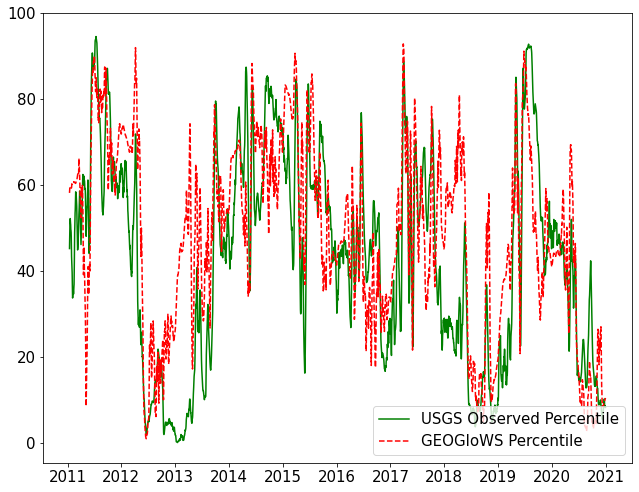

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.4678804543168993


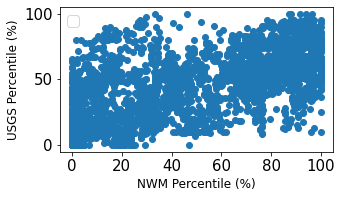

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.42470087569685


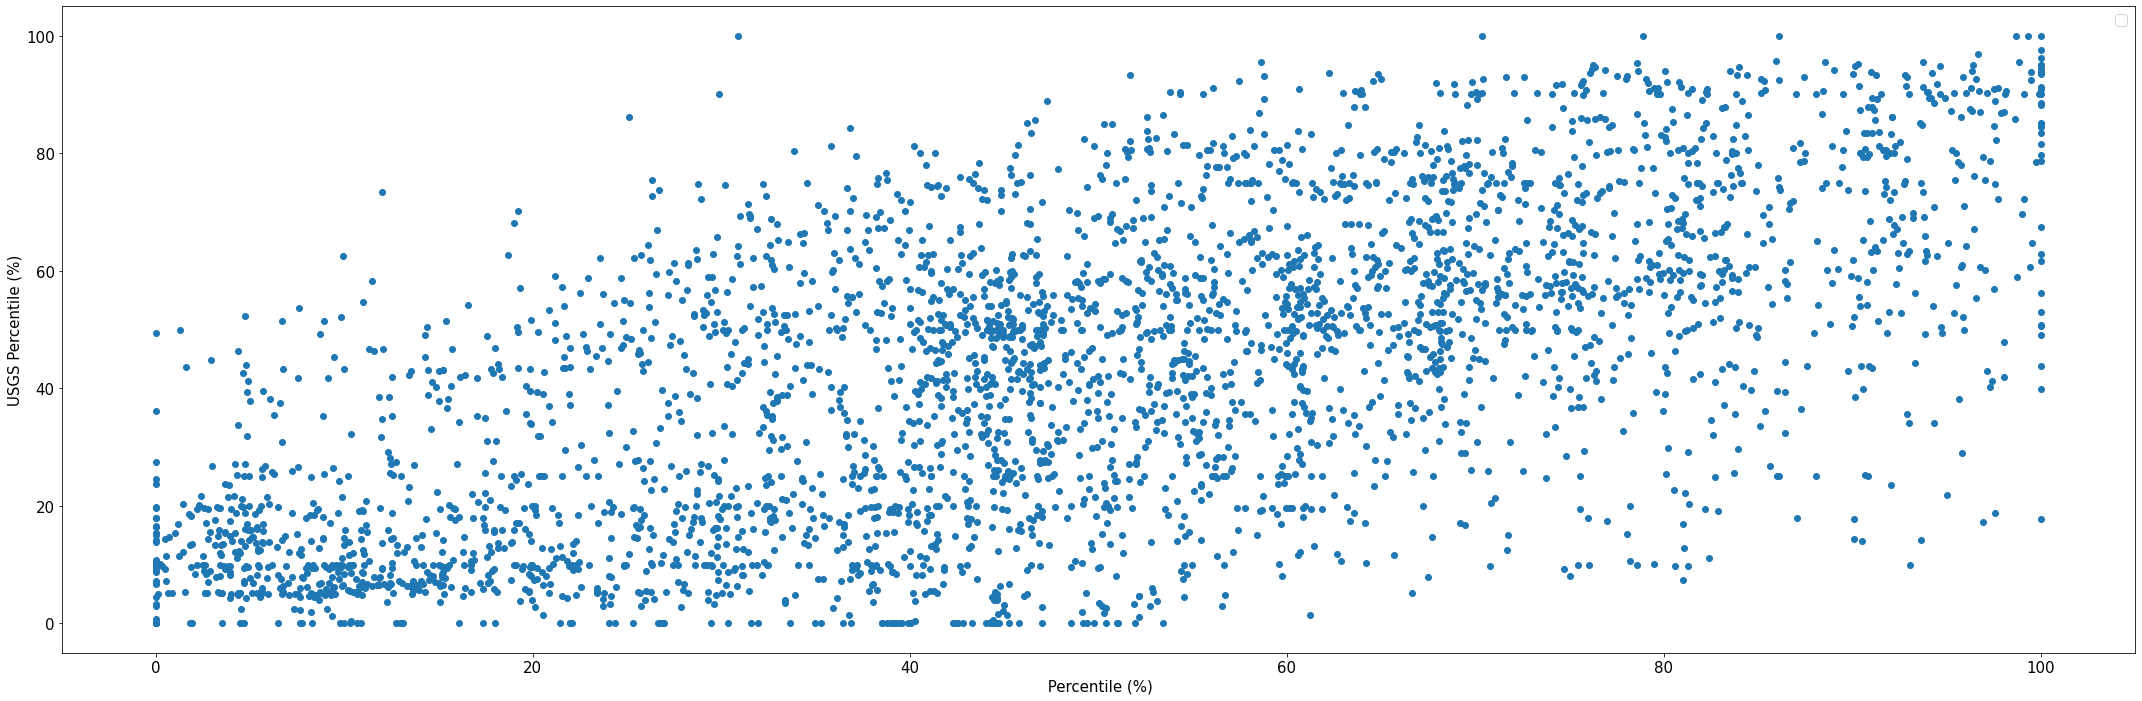

25.577789125308374
22.231360228013138


In [86]:
# filter, if necessary
# dataframe = dataframe[dataframe['usgs_percentiles'] < 25]

# dataframe = dataframe[(dataframe['usgs_percentiles'] >= 25) & (dataframe['usgs_percentiles'] <= 75)]

# dataframe = dataframe[dataframe['usgs_percentiles'] > 75]

# dataframe['month'] = pd.DatetimeIndex(dataframe['date']).month

# dataframe = dataframe[(dataframe['month'] >= 4) & (dataframe['month'] <= 6)]

# dataframe = dataframe[(dataframe['month'] != 4) & (dataframe['month'] != 5) & (dataframe['month'] != 6)]


# Calculate NSE
nwm_nse = nse(dataframe['nwm_percentiles'], dataframe['usgs_percentiles'])
grades_nse = nse(dataframe['geoglows_percentiles'], dataframe['usgs_percentiles'])

# print(nwm_nse)
# print(grades_nse)

# trying to smooth the curves here...
dataframe['usgs_mov_avg'] = dataframe['usgs_percentiles'].rolling(14).mean()
dataframe['nwm_mov_avg'] = dataframe['nwm_percentiles'].rolling(14).mean()
dataframe['geoglows_mov_avg'] = dataframe['geoglows_percentiles'].rolling(14).mean()

dataframe['date'] = pd.to_datetime(dataframe['date'])

# time_ar = dataframe.index.values
# usgs_ar = dataframe['usgs_percentiles'].values
# nwm_ar = dataframe['nwm_percentiles'].values
# geoglows_ar = dataframe['geoglows_percentiles'].values

# X_Y_Spline_usgs = make_interp_spline(time_ar, usgs_ar)
# # Returns evenly spaced numbers
# # over a specified interval.
# X_usgs = np.linspace(time_ar.min(), time_ar.max(), 5)
# Y_usgs = X_Y_Spline_usgs(X_usgs)

# X_Y_Spline_nwm = make_interp_spline(time_ar, nwm_ar)
# # Returns evenly spaced numbers
# # over a specified interval.
# X_nwm = np.linspace(time_ar.min(), time_ar.max(), 5)
# Y_nwm = X_Y_Spline_usgs(X_nwm)

# X_Y_Spline_geoglows = make_interp_spline(time_ar, geoglows_ar)
# # Returns evenly spaced numbers
# # over a specified interval.
# X_geoglows = np.linspace(time_ar.min(), time_ar.max(), 5)
# Y_geoglows = X_Y_Spline_usgs(X_geoglows)




# Create figure
fig = plt.figure(figsize=(9, 7))

plt.rcParams.update({'font.size': 15})




# Plot time series
plt.plot(dataframe['date'], dataframe['usgs_mov_avg'], color='green', 
         label='USGS Observed Percentile', linewidth=1.5)
# plt.plot(dataframe['date'], dataframe['nwm_mov_avg'], color='blue', 
#          label='NWM Percentile', linewidth=1.5)
plt.plot(dataframe['date'], dataframe['geoglows_mov_avg'], '--', color='red', 
         label='GEOGloWS Percentile', linewidth=1.5)

# Plot time series
# plt.plot(dataframe.index, dataframe['usgs_percentiles'], color='green', 
#          label='USGS Observed Percentile', linewidth=1)
# plt.plot(dataframe.index, dataframe['nwm_percentiles'], color='blue', 
#          label='NWM Percentile', linewidth=1)
# plt.plot(dataframe.index, dataframe['geoglows_percentiles'], color='red', 
#          label='GEOGloWS Percentile', linewidth=1)


# Add title and labels

# plt.title('Streamflow Percentile Comparison at USGS Gage {0}'.format(gage_number))
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Percentile (%)', fontsize=12)

# Add legend

plt.legend(loc='lower right')

# Auto space

plt.tight_layout()

plt.yticks(np.arange(0, 120, step=20))

# Display plot

plt.show() 




# build a scatter plot
# Create figure

fig = plt.figure(figsize=(5, 3))

#initiate linear regression model
model = LinearRegression()

X, y = dataframe[['nwm_percentiles']], dataframe['usgs_percentiles']

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)

print(r_squared)


plt.scatter(dataframe['nwm_percentiles'], dataframe['usgs_percentiles'])

# Add title and labels

# plt.title('Streamflow Percentile Comparison at USGS Gage {0}'.format(gage_number))
plt.xlabel('NWM Percentile (%)', fontsize=12)
plt.ylabel('USGS Percentile (%)', fontsize=12)

# Add legend

plt.legend()

# Auto space

plt.tight_layout()

# Display plot

plt.show() 







# build a scatter plot
# Create figure

fig = plt.figure(figsize=(30, 10))

#initiate linear regression model
model = LinearRegression()

X, y = dataframe[['geoglows_percentiles']], dataframe['usgs_percentiles']

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)

print(r_squared)


plt.scatter(dataframe['geoglows_percentiles'], dataframe['usgs_percentiles'])

# Add title and labels

#plt.title('Streamflow Percentile Comparison at USGS Gage {0}'.format(gage_number))
plt.xlabel(' Percentile (%)')
plt.ylabel('USGS Percentile (%)')

# Add legend

plt.legend()

# Auto space

plt.tight_layout()

# Display plot

plt.show() 


nwm_percent_rmse = ((dataframe['nwm_percentiles'] - dataframe['usgs_percentiles']) ** 2).mean() ** .5
print(nwm_percent_rmse)

geoglows_percent_rmse = ((dataframe['geoglows_percentiles'] - dataframe['usgs_percentiles']) ** 2).mean() ** .5
print(geoglows_percent_rmse)

0.56955302468668
-0.21147337206788897


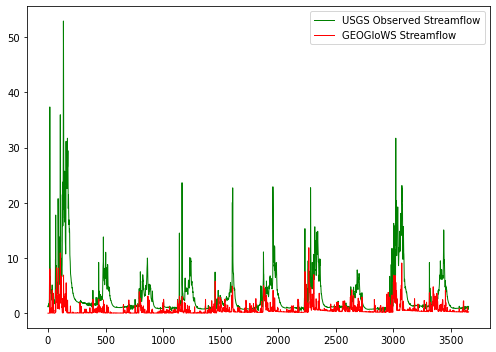

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.6659009381019154


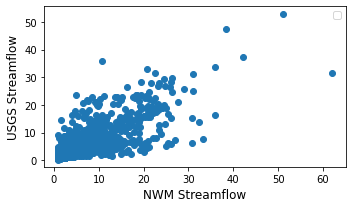

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.15891046001378362


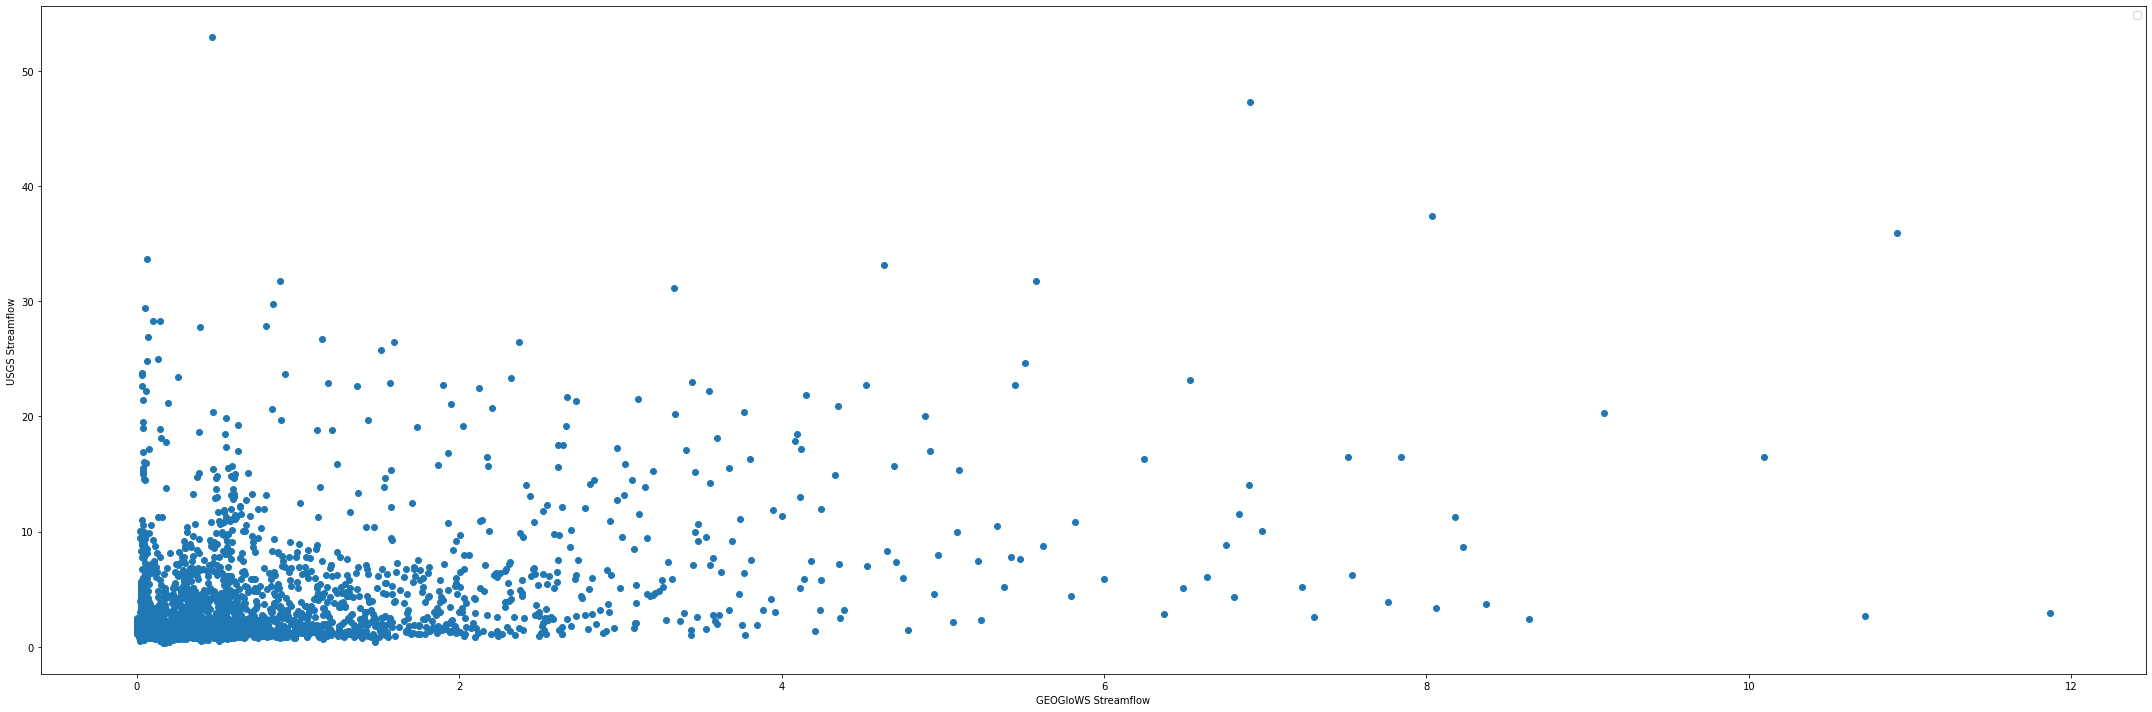

2.7975411654054674
4.693248954140926


In [56]:


# Calculate NSE
nwm_nse = nse(dataframe['nwm_flow'], dataframe['usgs_flows'])
grades_nse = nse(dataframe['geoglows_flows'], dataframe['usgs_flows'])

print(nwm_nse)
print(grades_nse)

# Create figure

fig = plt.figure(figsize=(7, 5))

# Plot time series
plt.plot(dataframe.index, dataframe['usgs_flows'], color='green', 
         label='USGS Observed Streamflow', linewidth=1)
# plt.plot(dataframe.index, dataframe['nwm_flow'], color='blue', 
#          label='NWM Streamflow', linewidth=1)
plt.plot(dataframe.index, dataframe['geoglows_flows'], color='red', 
         label='GEOGloWS Streamflow', linewidth=1)


# Add title and labels

# plt.title('Streamflow Comparison at USGS Gage {0}'.format(gage_number))
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Percentile (%)', fontsize=12)

# Add legend

plt.legend()

# Auto space

plt.tight_layout()

# Display plot

plt.show() 




# build a scatter plot
# Create figure

fig = plt.figure(figsize=(5, 3))

#initiate linear regression model
model = LinearRegression()

X, y = dataframe[['nwm_flow']], dataframe['usgs_flows']

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)

print(r_squared)


plt.scatter(dataframe['nwm_flow'], dataframe['usgs_flows'])

# Add title and labels

# plt.title('Streamflow Percentile Comparison at USGS Gage {0}'.format(gage_number))
plt.xlabel('NWM Streamflow', fontsize=12)
plt.ylabel('USGS Streamflow', fontsize=12)

# Add legend

plt.legend()

# Auto space

plt.tight_layout()

# Display plot

plt.show() 







# build a scatter plot
# Create figure

fig = plt.figure(figsize=(30, 10))

#initiate linear regression model
model = LinearRegression()

X, y = dataframe[['geoglows_flows']], dataframe['usgs_flows']

#fit regression model
model.fit(X, y)

#calculate R-squared of regression model
r_squared = model.score(X, y)

print(r_squared)


plt.scatter(dataframe['geoglows_flows'], dataframe['usgs_flows'])

# Add title and labels

#plt.title('Streamflow  Comparison at USGS Gage {0}'.format(gage_number))
plt.xlabel('GEOGloWS Streamflow')
plt.ylabel('USGS Streamflow')

# Add legend

plt.legend()

# Auto space

plt.tight_layout()

# Display plot

plt.show() 


nwm_percent_rmse = ((dataframe['nwm_flow'] - dataframe['usgs_flows']) ** 2).mean() ** .5
print(nwm_percent_rmse)

geoglows_percent_rmse = ((dataframe['geoglows_flows'] - dataframe['usgs_flows']) ** 2).mean() ** .5
print(geoglows_percent_rmse)

0.45387352860662467
0.3892690938954284


<AxesSubplot:xlabel='month'>

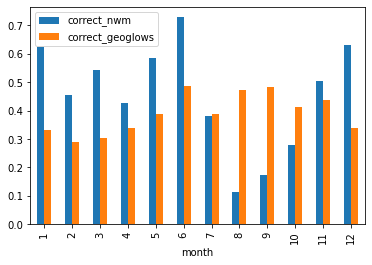

In [57]:
# cell for evaluating accuracy of NWM and GEOGloWS
conditions = [
    (dataframe['nwm_percentiles'] < 25) & (dataframe['usgs_percentiles'] < 25),
    (dataframe['nwm_percentiles'] >= 25) & (dataframe['usgs_percentiles'] >= 25) & (dataframe['nwm_percentiles'] <= 75) & (dataframe['usgs_percentiles'] <= 75),
    (dataframe['nwm_percentiles'] > 75) & (dataframe['usgs_percentiles'] > 75),
    (dataframe['nwm_percentiles'] < 25) & (dataframe['usgs_percentiles'] >= 25),
    (dataframe['nwm_percentiles'] >= 25) & (dataframe['usgs_percentiles'] < 25),
    (dataframe['nwm_percentiles'] > 75) & (dataframe['usgs_percentiles'] <= 75),
    (dataframe['nwm_percentiles'] <= 75) & (dataframe['usgs_percentiles'] > 75),
    (dataframe['nwm_percentiles'] >= 25) & (dataframe['nwm_percentiles'] <= 75) & (dataframe['usgs_percentiles'] < 25),
    (dataframe['nwm_percentiles'] >= 25) & (dataframe['nwm_percentiles'] <= 75) & (dataframe['usgs_percentiles'] > 75)
    ]

values = [1,1,1,0,0,0,0,0,0]


dataframe['correct_nwm'] = np.select(conditions, values)

print(dataframe['correct_nwm'].mean())

conditions = [
    (dataframe['geoglows_percentiles'] < 25) & (dataframe['usgs_percentiles'] < 25),
    (dataframe['geoglows_percentiles'] >= 25) & (dataframe['usgs_percentiles'] >= 25) & (dataframe['geoglows_percentiles'] <= 75) & (dataframe['usgs_percentiles'] <= 75),
    (dataframe['geoglows_percentiles'] > 75) & (dataframe['usgs_percentiles'] > 75),
    (dataframe['geoglows_percentiles'] < 25) & (dataframe['usgs_percentiles'] >= 25),
    (dataframe['geoglows_percentiles'] >= 25) & (dataframe['usgs_percentiles'] < 25),
    (dataframe['geoglows_percentiles'] > 75) & (dataframe['usgs_percentiles'] <= 75),
    (dataframe['geoglows_percentiles'] <= 75) & (dataframe['usgs_percentiles'] > 75),
    (dataframe['geoglows_percentiles'] >= 25) & (dataframe['geoglows_percentiles'] <= 75) & (dataframe['usgs_percentiles'] < 25),
    (dataframe['geoglows_percentiles'] >= 25) & (dataframe['geoglows_percentiles'] <= 75) & (dataframe['usgs_percentiles'] > 75)
    ]

values = [1,1,1,0,0,0,0,0,0]

dataframe['month'] = pd.DatetimeIndex(dataframe['date']).month

dataframe['correct_geoglows'] = np.select(conditions, values)


print(dataframe['correct_geoglows'].mean())

monthly_df = dataframe.groupby('month').mean()

monthly_df.plot(y=["correct_nwm", "correct_geoglows"], kind="bar", use_index=True)
